In [1]:
# Useful for multiple chartS: patchworklib

# https://github.com/has2k1/plotnine/issues/46

Recreate this chart in Plotnine

https://github.com/adamribaudo/storytelling-with-data-ggplot/blob/master/FIG0902.R

In [2]:
#pip install plotnine

## Import libraries
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import transforms
import pandas as pd
from pandas import CategoricalDtype


#import seaborn as sns
#from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from plotnine import *
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_line
from plotnine import ggplot  # https://plotnine.readthedocs.io/en/stable/
import pandas as pd
import plotnine
%matplotlib inline

from  mizani import formatters # for better axis labelling
from matplotlib.patches import Rectangle


In [3]:
# define colors
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
BLUE5, BLUE6 = '#92CDDD', '#2E869D'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1, ORANGE2, ORANGE3 = '#F79747', '#FAC090', '#F36721'

In [4]:
def color_title(labels, colors, textprops = {'size':'large'}, ax = None, y = 1,
               precision = 10**-2):
     
    "Creates a centered title with multiple colors. Don't change axes limits afterwards."
        
    if ax == None:
        ax = plt.gca()
        
    plt.gcf().canvas.draw()
    transform = ax.transAxes # use axes coords
    
    # initial params
    xT = 0 # where the text ends in x-axis coords
    shift = 0 # where the text starts
    
    # for text objects
    text = dict()

    while (np.abs(shift - (1-xT)) > precision) and (shift <= xT) :         
        x_pos = shift 
        
        for label, col in zip(labels, colors):
            try:
                text[label].remove()
            except KeyError:
                pass
            
            text[label] = ax.text(x_pos, y, label, 
                        transform = transform, 
                        ha = 'left',
                        color = col,
                        **textprops)
            
            x_pos = text[label].get_window_extent()\
                   .transformed(transform.inverted()).x1
            
        xT = x_pos # where all text ends
        
        shift += precision/2 # increase for next iteration
      
        if x_pos > 1: # guardrail 
            break

In [5]:
# empathy87 on github

def rainbow_text(x, y, text, colors, spacing=20, ax=None, **kw):
    colors = list(reversed(colors))
    t = ax.transData
    canvas = ax.figure.canvas

    for i, line in enumerate(reversed(text.split('\n'))):
        strings = line.split('||')
        for s, c in zip(strings, colors[i]):
            text = ax.text(x, y, s, color=c, transform=t, **kw)
            text.draw(canvas.get_renderer())
            ex = text.get_window_extent()
            t = transforms.offset_copy(text._transform, x=ex.width, 
                                       units='dots')

        t = transforms.offset_copy(ax.transData, x=0, y=(i + 1) * spacing, 
                                   units='dots')
        

In [6]:
# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'

#### Read in and process the data

In [7]:

#df = pd.read_csv ( 'Data\FIG0902.csv')

fileURL = 'https://raw.githubusercontent.com/steed360/Data-Wrangling-And-Visualisation-Toolkits/main/Data%20Visualisation/Plotnine/Data/data/FIG0902.csv' 

df = pd.read_csv ( fileURL)

# Unpivot the columns 'Bottom box', 'Middle', 'Top box'
df = pd.melt (df.reset_index(), 
    id_vars = 'item', 
    value_vars = ['Bottom box', 'Middle', 'Top box'] ,
    value_name='Percentage', var_name='Answer' )

df['Percentage'] = df['Percentage'].apply (lambda x: str(x).replace  ('%', '') ).astype(int) / 100
#df[ df.item == 'Survey item D']
df.head ()

,item,Answer,Percentage
0,Survey item A,Bottom box,0.01
1,Survey item B,Bottom box,0.05
2,Survey item C,Bottom box,0.08
3,Survey item D,Bottom box,0.11
4,Survey item A,Middle,0.66


In [47]:
df[ df.item == 'Survey item A']


,item,Answer,Percentage,value_label,value_label_a
0,Survey item A,Bottom box,0.01,,1%
4,Survey item A,Middle,0.66,,
8,Survey item A,Top box,0.33,33%,


In [9]:
# Get the column label text

df['value_label'] = ''
boolIndex =  ( (df['Answer']=='Bottom box') & (df['item'] != 'Survey item A') ) |   (df['Answer']=='Top box')
df.loc [   boolIndex , 'value_label' ]  = df['Percentage']
df['value_label'] = pd.to_numeric (df['value_label']) 

df['value_label_a'] = ''
boolIndex =   (df['Answer']=='Bottom box') & (df['item'] == 'Survey item A') 
df.loc [   boolIndex , 'value_label_a' ]  = df['Percentage']
df['value_label_a'] = pd.to_numeric (df['value_label_a']) 



In [10]:
# Sort the data order of the chart
# Column bars are plotted from Top Box, Middle Box, Bottom Box 
df['Answer'] = df.Answer.astype (CategoricalDtype(ordered=True))
df['Answer'] = df['Answer'].cat.reorder_categories(['Top box', 'Middle', 'Bottom box'])




In [11]:
df['item'] = df.item.astype (CategoricalDtype(ordered=True))
lstCats = [i for i in df['item'].unique()] # A,B,C,D (alphabetical)
df['item'] = df['item'].cat.reorder_categories( lstCats  )

# Could use format_string in geom_text but this shows nan% in the chart and I don't know how to get 
# rid of those.
df['value_label'] = df['value_label'].map ('{:.0%}'.format ).astype ('str').str.replace ('nan%', '')
df['value_label_a'] = df['value_label_a'].map ('{:.0%}'.format ).astype ('str').str.replace ('nan%', '')



In [12]:
df

,item,Answer,Percentage,value_label,value_label_a
0,Survey item A,Bottom box,0.01,,1%
1,Survey item B,Bottom box,0.05,5%,
2,Survey item C,Bottom box,0.08,8%,
3,Survey item D,Bottom box,0.11,11%,
4,Survey item A,Middle,0.66,,
5,Survey item B,Middle,0.83,,
6,Survey item C,Middle,0.83,,
7,Survey item D,Middle,0.80,,
8,Survey item A,Top box,0.33,33%,
9,Survey item B,Top box,0.12,12%,


In [72]:
def SWD_theme ():

    # Basic information from the 
    
    font = "Arial"
    t=theme_minimal(base_size = 10, base_family = font ) 

    t2 = theme(
      panel_grid_major = element_blank(),
      panel_grid_minor = element_blank(),

      axis_line = element_line(size = .1, color = GRAY9),
      axis_text = element_text(color = GRAY3, size = 12),

      #axis.ticks.x = element_line(size = 0.5, color = GRAY9),
      #axis.ticks.y = element_line(size = 0.5, color = GRAY9),
        
      axis_title = element_text(color = GRAY5),

      #axis_title_y = element_text(hjust = 1, margin = margin(0, 6, 0, 15, "pt")),
      #axis_title_x = element_text(hjust = 0, margin = margin(6, 0, 15, 0, "pt")),
      #plot_subtitle = element_text(color = GRAY4, size= 8),

      plot_title = element_text(color = GRAY4, size= 12 ),
        
      # I don't think this line is implemented in plotnine
      #plot_title_position = "plot", # This aligns the plot title to the very left edge
        
      #plot_caption = element_text(hjust = 0, color = GRAY6),
      #plot_caption_position = "plot",

      #plot_margin = margin(.5,.5,.5,.5,"cm"),
      plot_margin = (0.1 ),  
        
      strip_text = element_text(color = GRAY7)) 
    
    return t+ t2


In [62]:
# This list will allow us to order the y axis on the final chart.
l = list ( reversed (df.item.value_counts ( ).index.tolist() ) )
l = list ( df.item.value_counts ( ).index.tolist() ) 

l

['Survey item A', 'Survey item B', 'Survey item C', 'Survey item D']

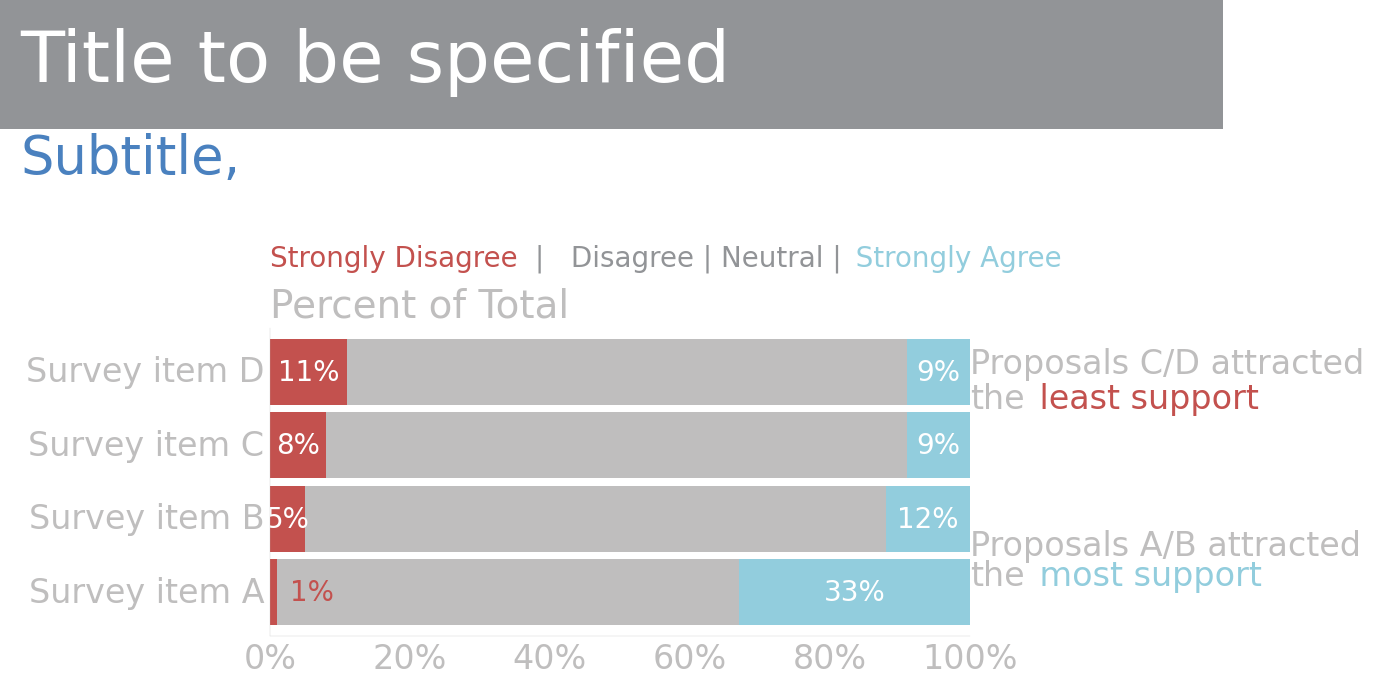

In [92]:
from plotnine.themes.themeable import axis_ticks
t = theme(         
          # Overrides
          axis_title_y = element_text(angle = 90, va = 'bottom', ha = 'left', size = 15, color = GRAY9 ), #, y = 0.52), 

          # Turn off tick labels
          axis_ticks_length=0, 
          
          #text=element_text(color="red"),
          axis_text=element_text(color=GRAY9),

          axis_text_x=element_text(color=GRAY9),
          axis_text_y=element_text(color=GRAY9),          

          panel_grid_major_y=element_blank() ,
          axis_title_x=element_text(angle = 0, va = 'top',ha='left' , size = 14, color = GRAY9 , x=0.1) #, y = 0.52)          
)

fig = ( ggplot(aes(x = 'item', y = 'Percentage', fill = 'Answer'), data=df ) +

  geom_col()  + 

  scale_y_continuous(
                     labels = formatters.percent_format(),
                     breaks = [0,.2,.4, .6 , .8,  1],
                     expand = [0,0])  +
  
  scale_x_discrete ( limits= l ) +

  scale_fill_manual(guide = False, 
                    values = [BLUE5,GRAY9,RED1]) + 
       
  geom_text ( aes(label = ( 'value_label'  )  ), 
            position = position_stack(vjust = 0.5),
            color = "white", size = 10 ) +

  geom_text ( aes(label = ( 'value_label_a'  )  ), 
            position = position_stack(vjust = 0.95),
            color = RED1, size = 10, nudge_y=0.05 ) +
  
  SWD_theme () + t + 

  labs ( y='Percent of Total',x= '') +

  coord_flip() 

       
).draw(show=False, return_ggplot=False)

# Blank axis for title, notes (and to fill the screen.)
ax0 = fig.add_axes( (0,0,1,1))
ax0.axis('Off') # don't draw anything.

############################################


#Title
ax0.text( -0.15 , 0.9,
         'Title to be specified' + ' '*20,
         fontsize=26,
         color='white',
         # put a rectangular box around the text to set a background color
         bbox={'facecolor': GRAY7, 'pad': 12, 'edgecolor': "None"})


# Subtitle
plt.text(-0.15, 0.75,
         'Subtitle,',
         fontsize=19,
         color=BLUE2)

# x label at top of chart

#ax1.xaxis.set_label_coords(0.15, 1.14)
#ax1.xlabel('Percentage of total',fontsize=14,color =GRAY5)
#fig.canvas.draw() # this is essential


####################################################


# Having got the plot make some other annotations.
ax1 = fig.axes[0]

# Move our chart down a bit to give room for title etc.
# left, bottom, width, height ( 1,1)

ax1.xaxis.set_label_position('top') 
#ax1.xaxis.set_ticks_position ('top')

ax1.set_position  (pos=  [0.1, 0 ,0.7,0.5] )

###########################################


# Add Legend to above the chart.
cols  = [RED1,GRAY7,BLUE5]
words = ['Strongly Disagree', '        |   Disagree | Neutral |', '           Strongly Agree']
color_title ( colors=cols, labels= words, ax=ax1, textprops= {'size':'medium'}, y=1.2)

rainbow_text(
    1, 1.1,
    'Proposals A/B attracted\nthe||    most support', 
    colors=[[GRAY9], 
           [GRAY9,BLUE5]]
    ,ax=ax1,
    fontsize=12, spacing=30)

rainbow_text(
    1, 3.5,
    'Proposals C/D attracted\nthe||    least support', 
    colors=[[GRAY9], 
           [GRAY9,RED1]]
    ,ax=ax1,
    fontsize=12, spacing=35)

fig.dpi = 200
width_in = 5
fig.set_size_inches(width_in , width_in/1.62) 

